In [1]:
import time
import os
import copy
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import numpy as np
torch.manual_seed(42)
np.random.seed(42)
# Plotting
import matplotlib.pyplot as plt
# OpenMP: number of parallel threads.
#os.environ["OMP_NUM_THREADS"] = "1"

step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 20              # Number of training epochs
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset Import, Change transforms fields for changing augmentation

For minimal code changes have two folders train and val, with sub folders for classes (Same names and letter cases for train and val)

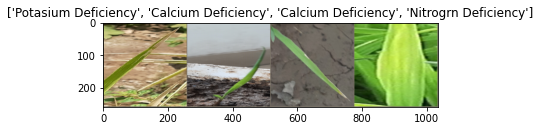

In [2]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "validation": transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "./tt/"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "validation"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"])) #changed to val from validation
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

ResNet

In [7]:
model_hybrid = torchvision.models.resnet18(pretrained=False)

for param in model_hybrid.parameters():
    param.requires_grad = True
    
model_hybrid.fc = nn.Linear(512,3)
# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

start_time = time.time() 
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/20 Loss: 1.2114 Acc: 0.4297        
Phase: validation   Epoch: 1/20 Loss: 1.1465 Acc: 0.4343        
Phase: train Epoch: 2/20 Loss: 0.9533 Acc: 0.5521        
Phase: validation   Epoch: 2/20 Loss: 1.1537 Acc: 0.5152        
Phase: train Epoch: 3/20 Loss: 0.9304 Acc: 0.5729        
Phase: validation   Epoch: 3/20 Loss: 0.9941 Acc: 0.5758        
Phase: train Epoch: 4/20 Loss: 0.9337 Acc: 0.5417        
Phase: validation   Epoch: 4/20 Loss: 1.0076 Acc: 0.4040        
Phase: train Epoch: 5/20 Loss: 0.8919 Acc: 0.5443        
Phase: validation   Epoch: 5/20 Loss: 1.2321 Acc: 0.4949        
Phase: train Epoch: 6/20 Loss: 0.8818 Acc: 0.5833        
Phase: validation   Epoch: 6/20 Loss: 1.0001 Acc: 0.5051        
Phase: train Epoch: 7/20 Loss: 0.8271 Acc: 0.6120        
Phase: validation   Epoch: 7/20 Loss: 0.9858 Acc: 0.5859        
Phase: train Epoch: 8/20 Loss: 0.7808 Acc: 0.6224        
Phase: validation   Epoch: 8/20 Loss: 0.9594 Acc: 0.5657       

DenseNet

In [8]:
model_hybrid = torchvision.models.densenet161(pretrained=False)
for param in model_hybrid.parameters():
    param.requires_grad = True
num_ftrs = model_hybrid.classifier.in_features
model_hybrid.classifier = nn.Linear(num_ftrs, 512)
model_hybrid.fc = nn.Linear(512, 3)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

start_time = time.time() 
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/20 Loss: 1.4332 Acc: 0.4557        
Phase: validation   Epoch: 1/20 Loss: 1.8954 Acc: 0.4242        
Phase: train Epoch: 2/20 Loss: 1.0944 Acc: 0.4740        
Phase: validation   Epoch: 2/20 Loss: 0.8797 Acc: 0.5455        
Phase: train Epoch: 3/20 Loss: 0.9157 Acc: 0.5755        
Phase: validation   Epoch: 3/20 Loss: 2.6120 Acc: 0.5960        
Phase: train Epoch: 4/20 Loss: 0.9464 Acc: 0.5651        
Phase: validation   Epoch: 4/20 Loss: 1.0358 Acc: 0.5253        
Phase: train Epoch: 5/20 Loss: 0.9653 Acc: 0.5469        
Phase: validation   Epoch: 5/20 Loss: 0.9357 Acc: 0.6162        
Phase: train Epoch: 6/20 Loss: 0.8485 Acc: 0.5703        
Phase: validation   Epoch: 6/20 Loss: 2.9186 Acc: 0.4747        
Phase: train Epoch: 7/20 Loss: 0.9184 Acc: 0.5547        
Phase: validation   Epoch: 7/20 Loss: 1.5861 Acc: 0.3535        
Phase: train Epoch: 8/20 Loss: 0.9121 Acc: 0.5729        
Phase: validation   Epoch: 8/20 Loss: 0.8637 Acc: 0.6364       

Add other models which are available at: https://pytorch.org/vision/stable/models.html change the final layer based on architecture, if tranfer learnng is to be used, change pretrain to true and param.requires_grad to false 

In [4]:
model_hybrid = torchvision.models.vgg16(pretrained=False)

for param in model_hybrid.parameters():
    param.requires_grad = True
    
model_hybrid.fc = nn.Linear(512,3)
# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

start_time = time.time() 
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/20 Loss: 1.9240 Acc: 0.4219        
Phase: validation   Epoch: 1/20 Loss: 1.1494 Acc: 0.4747        
Phase: train Epoch: 2/20 Loss: 1.0905 Acc: 0.4479        
Phase: validation   Epoch: 2/20 Loss: 1.1292 Acc: 0.1818        
Phase: train Epoch: 3/20 Loss: 1.1110 Acc: 0.4323        
Phase: validation   Epoch: 3/20 Loss: 1.0542 Acc: 0.4747        
Phase: train Epoch: 4/20 Loss: 1.1052 Acc: 0.4193        
Phase: validation   Epoch: 4/20 Loss: 1.0520 Acc: 0.4747        
Phase: train Epoch: 5/20 Loss: 1.0976 Acc: 0.4557        
Phase: validation   Epoch: 5/20 Loss: 1.0334 Acc: 0.4747        
Phase: train Epoch: 6/20 Loss: 1.0804 Acc: 0.4766        
Phase: validation   Epoch: 6/20 Loss: 1.0585 Acc: 0.4747        
Phase: train Epoch: 7/20 Loss: 1.1086 Acc: 0.4167        
Phase: validation   Epoch: 7/20 Loss: 1.0809 Acc: 0.4747        
Phase: train Epoch: 8/20 Loss: 1.0792 Acc: 0.4688        
Phase: validation   Epoch: 8/20 Loss: 1.0273 Acc: 0.4747       

In [5]:
model_hybrid = torchvision.models.squeezenet1_1(pretrained=False)

for param in model_hybrid.parameters():
    param.requires_grad = True
    
model_hybrid.fc = nn.Linear(512,3)
# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

start_time = time.time() 
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/20 Loss: 1.7119 Acc: 0.3880        
Phase: validation   Epoch: 1/20 Loss: 1.1713 Acc: 0.4747        
Phase: train Epoch: 2/20 Loss: 1.2646 Acc: 0.3802        
Phase: validation   Epoch: 2/20 Loss: 1.0511 Acc: 0.4747        
Phase: train Epoch: 3/20 Loss: 1.1099 Acc: 0.4401        
Phase: validation   Epoch: 3/20 Loss: 1.0154 Acc: 0.4747        
Phase: train Epoch: 4/20 Loss: 1.1795 Acc: 0.4141        
Phase: validation   Epoch: 4/20 Loss: 1.0154 Acc: 0.5253        
Phase: train Epoch: 5/20 Loss: 1.0771 Acc: 0.4505        
Phase: validation   Epoch: 5/20 Loss: 0.9738 Acc: 0.4747        
Phase: train Epoch: 6/20 Loss: 0.9812 Acc: 0.5104        
Phase: validation   Epoch: 6/20 Loss: 1.1552 Acc: 0.5354        
Phase: train Epoch: 7/20 Loss: 1.0454 Acc: 0.4688        
Phase: validation   Epoch: 7/20 Loss: 1.0594 Acc: 0.4343        
Phase: train Epoch: 8/20 Loss: 1.0076 Acc: 0.5339        
Phase: validation   Epoch: 8/20 Loss: 0.9792 Acc: 0.6768       